# **CitiBike Ridership Analysis Before, During and After Lockdown**

Citibike is a bike sharing system serving New York and New Jersey Area.. I have chosen to do the analyisis for the month of July, August and September. I have chosen to do the analyisis for the month of June, July and August. The minimum and maximum tempertaure for these months is 64 and 84 degree, which make them to be favorable for bike riders.

<h1>What is going to be covered in this notebook?</h1>

This project analyses the ridership in NYC before, during and after pandemic in following areas: 
- How total number of rides has changed throughout
- Subscriber and Casual Customer Consumer Behavior
- Pick days before, during and after the pandemic
- Analysis of newly introduced e-bike
- Charing stations clusters for e-bikes
- Communities based on distance by using Louvain Communities



Data Source: https://s3.amazonaws.com/tripdata/index.html

In [1]:
#If you're using Paperspace and would like to share access while your instance is running, uncomment this cell. If you don't have paperspace, ignore this.
# import os
# os.environ['JUPYTER_TOKEN']

<h1>Download Your Data</h1>

In [1]:
import urllib.request
import os

data_dir = './data/trips/'
if not os.path.exists(data_dir):
    print('creating a directory')
    os.system('mkdir ./data')
    os.system('mkdir ./data/trips')

In [3]:
base_url = "https://s3.amazonaws.com/tripdata/"
months = ["202007-citibike-tripdata","202008-citibike-tripdata", "202009-citibike-tripdata", "JC-201907-citibike-tripdata", "JC-201908-citibike-tripdata","JC-201909-citibike-tripdata","JC-202107-citibike-tripdata","JC-202108-citibike-tripdata","JC-202109-citibike-tripdata",]
for month in months:
    fn = str(month) + '.csv.zip'
    if not os.path.isfile(data_dir+fn):
        print(f'Downloading {base_url+fn} to {data_dir+fn}')
        urllib.request.urlretrieve(base_url+fn, data_dir+fn)

In [2]:
!ls ./data/trips

202007-citibike-tripdata.csv	 JC-201909-citibike-tripdata.csv
202008-citibike-tripdata.csv	 JC-202107-citibike-tripdata.csv
202009-citibike-tripdata.csv	 JC-202108-citibike-tripdata.csv
JC-201907-citibike-tripdata.csv  JC-202109-citibike-tripdata.csv
JC-201908-citibike-tripdata.csv  __MACOSX


**Import the dependencies and libraries to be used in this project**

In [3]:
import pandas as pd
import numpy as np
import glob
import os

import cudf
import cuxfilter
import matplotlib.pyplot as plt
import seaborn as sns
from cuxfilter import DataFrame, themes, layouts
from cuxfilter.assets.custom_tiles import get_provider, Vendors
from cuxfilter.charts import bokeh, datashader, panel_widgets
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Hot
from pyproj import Proj, Transformer
from bokeh import palettes
from cuxfilter.layouts import double_feature

<h1>Read Your Data</h1>

In [4]:
import zipfile

extension = ".zip"
data_dir = './data/trips/'



for item in os.listdir(data_dir): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = data_dir + "/" + item # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(data_dir) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

In [5]:
all_files = glob.glob(data_dir + "*csv")
all_files.sort()
all_files

['./data/trips/202007-citibike-tripdata.csv',
 './data/trips/202008-citibike-tripdata.csv',
 './data/trips/202009-citibike-tripdata.csv',
 './data/trips/JC-201907-citibike-tripdata.csv',
 './data/trips/JC-201908-citibike-tripdata.csv',
 './data/trips/JC-201909-citibike-tripdata.csv',
 './data/trips/JC-202107-citibike-tripdata.csv',
 './data/trips/JC-202108-citibike-tripdata.csv',
 './data/trips/JC-202109-citibike-tripdata.csv']

In [6]:
df = cudf.read_csv(all_files[0]) # we're keeping this
df19 = cudf.read_csv(all_files[3])
df21 = cudf.read_csv(all_files[-1]) # gets last file
print(df19.dtypes)
print(df.dtypes)
print(df21.dtypes)

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                   int64
gender                       int64
dtype: object
tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth 

Seems that in 2021, there is a header change, so we can't read all the data into a single dataframe....yet

In [7]:
for i in range(1, len(all_files)): 
    if("2021" in all_files[i]):
        continue #let's skip them for now
    else:
        tempdf = cudf.read_csv(all_files[i])     
                
    df= cudf.concat([df,tempdf], ignore_index=True, sort=False) 
df.count()

tripduration               7065248
starttime                  7065248
stoptime                   7065248
start station id           7065248
start station name         7065248
start station latitude     7065248
start station longitude    7065248
end station id             7065248
end station name           7065248
end station latitude       7065248
end station longitude      7065248
bikeid                     7065248
usertype                   7065248
birth year                 7065248
gender                     7065248
dtype: int64

Do some quick data forming...

In [8]:
df=df.rename( columns ={ "start station id": "start_station_id",
                       "start station name": "start_station_name",
                       "start station latitude": "start_lat",
                       "start station longitude": "start_lng",
                       "end station id": "end_station_id",
                       "end station name": "end_station_name",
                       "end station latitude": "end_lat",
                       "end station longitude": "end_lng",
                       "usertype": "member_casual",
                       "starttime": "started_at",
                       "stoptime": "ended_at"
                    }) 
df["start_station_id"]=df["start_station_id"].astype(str)
df["end_station_id"]=df["end_station_id"].astype(str)
df["started_at"]=cudf.to_datetime(df["started_at"])
df["ended_at"]=cudf.to_datetime(df["ended_at"])
print(df.dtypes)

tripduration                   int64
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_id              object
start_station_name            object
start_lat                    float64
start_lng                    float64
end_station_id                object
end_station_name              object
end_lat                      float64
end_lng                      float64
bikeid                         int64
member_casual                 object
birth year                     int64
gender                         int64
dtype: object


In [9]:
for i in range(0, len(all_files)):
    if("2021" in all_files[i]):
        tempdf = cudf.read_csv(all_files[i])
        tempdf['started_at']=cudf.to_datetime(tempdf['started_at']) # change to tempdf
        tempdf['ended_at']=cudf.to_datetime(tempdf['ended_at'])
        tempdf['tripduration']= (tempdf['ended_at'] - tempdf['started_at'])/np.timedelta64(1,'s')
        tempdf['tripduration']= tempdf['tripduration'].astype(np.int64)
        df = cudf.concat([df,tempdf], ignore_index=True, sort=False) 

In [10]:
df

,tripduration,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,end_lng,bikeid,member_casual,birth year,gender,ride_id,rideable_type
0,341,2020-07-01 00:00:01.302,2020-07-01 00:05:42.565,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,-73.980544,33861,Subscriber,1986,1,<NA>,<NA>
1,321,2020-07-01 00:00:01.362,2020-07-01 00:05:22.949,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,-73.980544,31233,Subscriber,1990,2,<NA>,<NA>
2,2710,2020-07-01 00:00:06.629,2020-07-01 00:45:17.341,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,-74.006818,40329,Customer,1969,0,<NA>,<NA>
3,2685,2020-07-01 00:00:13.022,2020-07-01 00:44:58.864,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,-74.006818,17567,Subscriber,1998,1,<NA>,<NA>
4,191,2020-07-01 00:00:13.466,2020-07-01 00:03:24.623,3615,44 Dr & 21 St,40.748000,-73.946093,3127,9 St & 44 Rd,40.749660,-73.952100,43421,Subscriber,1992,1,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7338955,411,2021-09-09 21:23:45.000,2021-09-09 21:30:36.000,JC035,Van Vorst Park,40.718489,-74.047727,JC077,Astor Place,40.719282,-74.071262,<NA>,member,<NA>,<NA>,69D4734AC92BC7D7,electric_bike
7338956,779,2021-09-18 23:39:37.000,2021-09-18 23:52:36.000,JC035,Van Vorst Park,40.718489,-74.047727,JC077,Astor Place,40.719282,-74.071262,<NA>,member,<NA>,<NA>,A54DD2451E15595B,classic_bike
7338957,848,2021-09-28 16:43:48.000,2021-09-28 16:57:56.000,JC032,Newark Ave,40.721525,-74.046305,JC077,Astor Place,40.719282,-74.071262,<NA>,member,<NA>,<NA>,D5D3F49E376ECC8B,classic_bike
7338958,529,2021-09-24 15:37:20.000,2021-09-24 15:46:09.000,JC053,Lincoln Park,40.724605,-74.078406,JC077,Astor Place,40.719282,-74.071262,<NA>,casual,<NA>,<NA>,335098A4D62D303F,classic_bike


<h1>How total number of rides changed throughout?</h1>

In [11]:
df['started_at']=df['started_at'].astype('datetime64[s]')
df['ended_at']=df['ended_at'].astype('datetime64[s]')
df['day_of_the_month']=df['started_at'].dt.day
df['start_hour_of_the_day']= df['started_at'].dt.hour
df['stop_hour_of_the_day']= df['ended_at'].dt.hour
df['dow']= df['started_at'].dt.dayofweek
df['month']=df['started_at'].dt.month
df['day_of_week'] = df['started_at'].dt.weekday
df['is_weekend'] = (df['day_of_week']>=5).astype('int32')
df['year']=df['started_at'].dt.year

**First, get the Total Trips throughout**

1. Get Total Trips for 2019 Summer.

In [12]:
years = df['year'].value_counts()
print(years)

2020    6923547
2021     273712
2019     141701
Name: year, dtype: int32


In [13]:
years=years.reset_index()
years=years.rename(columns={'index':'year', 'year':'count'})
years

,year,count
0,2020,6923547
1,2021,273712
2,2019,141701


**Getting the percentage change in ridership for 3 years**

In [25]:
years= years.sort_values('year')
years['diff#']= years['count'].diff().fillna(0)
years['diff%']= (years['count'].pct_change().fillna(0))*100
years = years.rename(columns={'count':'Total Number of Rides'})

**Plot the table with Cuxfilter**

In [26]:
#Read the dataframe in cuxfilter
cux_df = cuxfilter.DataFrame.from_dataframe(years)
cux_df.data.head()

,year,Total Number of Rides,diff#,diff%
2,2019,141701,0,0.000000
0,2020,6923547,6781846,4786.025504
1,2021,273712,-6649835,-96.046651


In [27]:
#Plot the chat
chart3 = cuxfilter.charts.bar(x='year', y='Total Number of Rides', title="Total Rides before, during and after the Pandemic")
d = cux_df.dashboard([chart3])
chart3.view()

Card(sizing_mode='scale_width', title='Total Rides before, ..., width=400)
    [0] Bokeh(Figure)
    [1] RangeSlider(end=2021, sizing_mode='scale_width', start=2019, step=1, value=(2019, 2021), value_end=2021, value_start=2019, width=400)

# **Subscribers And Customers Behaviour**

**1.Get the count of each user type for every year**

i. Get the count for each usertype for each year

In [30]:
#Usertype count for 2019
xa=df.groupby(['year','member_casual']).agg({'member_casual': ['count']}).reset_index()
xa.columns = xa.columns.get_level_values(0) +  xa.columns.get_level_values(1)
xa['member_casual']=xa['member_casual'].replace({'casual':'Customer', 'member':'Subscriber'})
xa=xa.rename(columns={'member_casual':'Membership Type', 'member_casualcount':'Total'})
xa

,year,Membership Type,Total
0,2019,Customer,21028
1,2019,Subscriber,120673
2,2020,Customer,1902977
3,2020,Subscriber,5020570
4,2021,Customer,122849
5,2021,Subscriber,150863


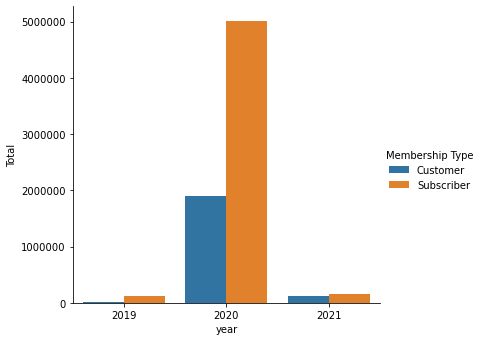

In [31]:
#Plot the graph
sns.factorplot(x='year', y='Total', hue='Membership Type', kind='bar', data=xa.to_pandas())
plt.ticklabel_format(style='plain', axis='y')

**2.Trip Durations comparison for each User Type**

Grouby Usertype and calculate median duration for each group

In [34]:
ya=df.groupby(['year','member_casual']).agg({'tripduration': ['median']}).reset_index()
ya.columns = ya.columns.get_level_values(0) +  ya.columns.get_level_values(1)
ya['member_casual']=ya['member_casual'].replace({'casual':'Customer', 'member':'Subscriber'})
ya=ya.rename(columns={'member_casual':'Membership Type', 'tripdurationmedian':'Median Trip Duration(Secs)'})
ya

,year,Membership Type,Median Trip Duration(Secs)
0,2019,Customer,840.0
1,2019,Subscriber,336.0
2,2020,Customer,1192.0
3,2020,Subscriber,739.0
4,2021,Customer,686.0
5,2021,Subscriber,426.0


In [35]:
#Change the dataframe into pandas
pdftrip=ya.to_pandas()

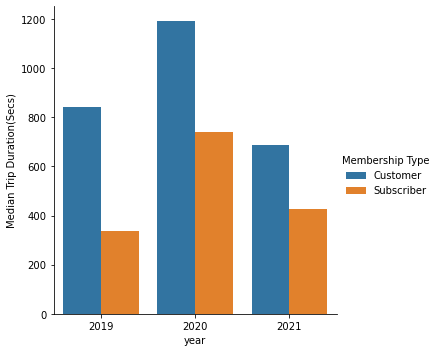

In [37]:
#Plotting
sns.factorplot(x='year', y='Median Trip Duration(Secs)', hue='Membership Type', kind='bar', data=pdftrip)
plt.ticklabel_format(style='plain', axis='y')

<h1>Peak days before, during and after the pandemic</h1>

In [45]:
peakdays= df.groupby(['year','dow']).agg({'dow': ['count']}).reset_index()
peakdays.columns = peakdays.columns.get_level_values(0) +  peakdays.columns.get_level_values(1)
peakdays['dow'] = peakdays['dow'].map(dict(zip([0,1,2,3,4,5,6],['Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])))
peakdays=peakdays.rename(columns={'dow':'Day', 'dowcount':'Total Rides'})
peakdays.head()

,year,Day,Total Rides
0,2020,Friday,958984
1,2020,Saturday,1116324
2,2019,Saturday,17884
3,2020,Tuesday,942154
4,2021,Tuesday,38132


In [47]:
ppeakdays=peakdays.to_pandas()

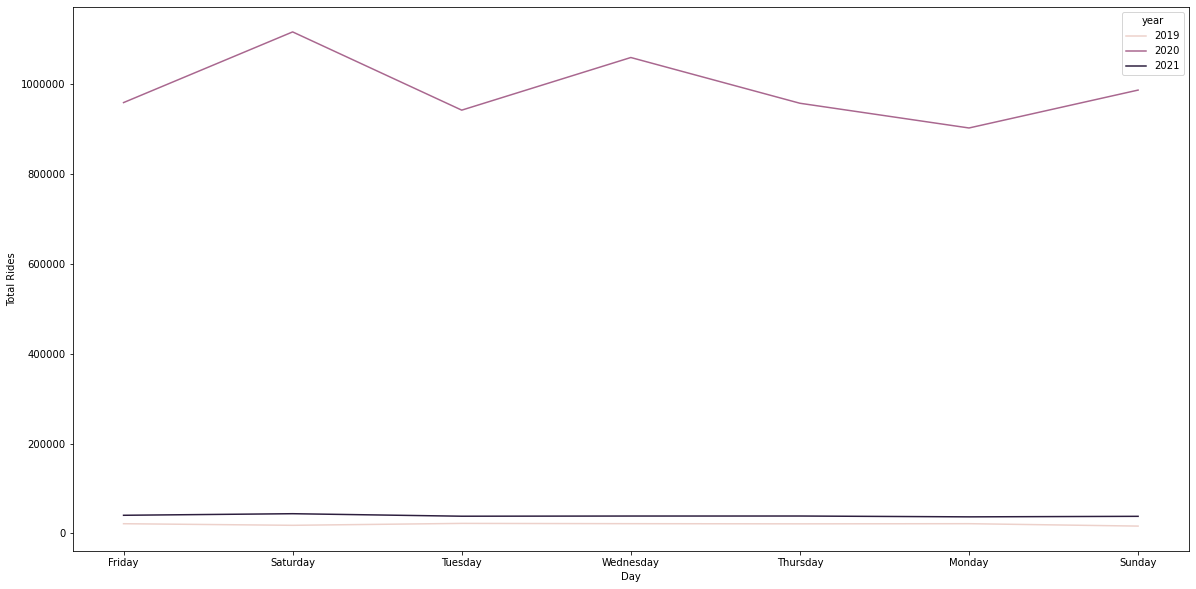

In [48]:
plt.figure(figsize=(20,10))
#sns.set(font_scale=2)

sns.lineplot(data=ppeakdays, x="Day", y="Total Rides", hue="year")
plt.ticklabel_format(style='plain', axis='y')

# **Electronic Bikes**

**How many Customers and Subscribers used electrical bikes and other types of bikes?**

In [49]:
types=df.groupby(['rideable_type','member_casual']).agg({'member_casual': ['count']}).reset_index()

types.columns=['Bike Type', 'Membership Type', 'Total Rides']
types.head()

,Bike Type,Membership Type,Total Rides
0,classic_bike,casual,73950
1,classic_bike,member,113685
2,docked_bike,casual,4489
3,electric_bike,casual,44410
4,electric_bike,member,37178


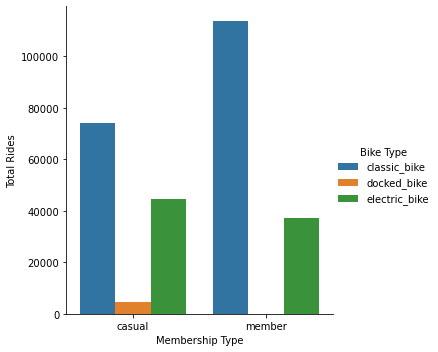

In [50]:
ptypes=types.to_pandas()
#plt.figure(figsize=(20,10))
#sns.set(font_scale=0.8)
sns.factorplot(x='Membership Type', y='Total Rides', hue='Bike Type', kind='bar', data=ptypes)

**What were the trip Durations fro each type of bike per User categories?**

In [51]:
typesd=df.groupby(['rideable_type','member_casual']).agg({'tripduration': ['sum']}).reset_index()

typesd.columns=['Bike Type', 'Membership Type', 'Total Duration(Secs)']
typesd.head()

,Bike Type,Membership Type,Total Duration(Secs)
0,classic_bike,member,89078602
1,electric_bike,casual,58227723
2,docked_bike,casual,53303422
3,classic_bike,casual,120475324
4,electric_bike,member,23988039


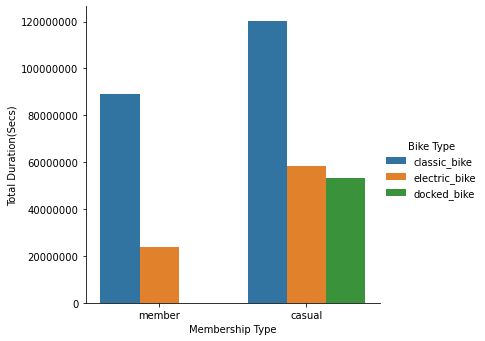

In [53]:
ptypes=typesd.to_pandas()
sns.factorplot(x='Membership Type', y='Total Duration(Secs)', hue='Bike Type', kind='bar', data=ptypes)
plt.ticklabel_format(style='plain', axis='y')

# **Knn Means to Make Clusters for E-bikes Stations**

In [32]:
from cuml import KMeans
from cuml.cluster import KMeans
import numpy as np
import pandas as pd
import cuspatial

**Use Kmeans to predict clusters based on latitude and longitudes**

In [33]:
coord = df[["start_lat", "start_lng"]].values
kmeans = KMeans(n_clusters=40).fit(coord)
df['pickup_cluster'] = kmeans.predict(df[["start_lat", "start_lng"]])
df.head()

,tripduration,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,...,rideable_type,day_of_the_month,start_hour_of_the_day,stop_hour_of_the_day,dow,month,day_of_week,is_weekend,year,pickup_cluster
0,341,2020-07-01 00:00:01,2020-07-01 00:05:42,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,...,<NA>,1,0,0,2,7,2,0,2020,27
1,321,2020-07-01 00:00:01,2020-07-01 00:05:22,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,...,<NA>,1,0,0,2,7,2,0,2020,27
2,2710,2020-07-01 00:00:06,2020-07-01 00:45:17,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,...,<NA>,1,0,0,2,7,2,0,2020,12
3,2685,2020-07-01 00:00:13,2020-07-01 00:44:58,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,...,<NA>,1,0,0,2,7,2,0,2020,12
4,191,2020-07-01 00:00:13,2020-07-01 00:03:24,3615,44 Dr & 21 St,40.748000,-73.946093,3127,9 St & 44 Rd,40.749660,...,<NA>,1,0,0,2,7,2,0,2020,38


In [34]:
df.isna().sum()

tripduration                   0
started_at                     0
ended_at                       0
start_station_id               0
start_station_name             0
start_lat                      0
start_lng                      0
end_station_id              1736
end_station_name            1736
end_lat                     1155
end_lng                     1155
bikeid                    273712
member_casual                  0
birth year                273712
gender                    273712
ride_id                  7065248
rideable_type            7065248
day_of_the_month               0
start_hour_of_the_day          0
stop_hour_of_the_day           0
dow                            0
month                          0
day_of_week                    0
is_weekend                     0
year                           0
pickup_cluster                 0
dtype: int64

In [35]:
df1 = df.dropna(subset=['end_station_id'])

Change latitude to longitude to mercator coorditanes and use bokeh map for plotting

In [36]:
df1.isna().sum()

tripduration                   0
started_at                     0
ended_at                       0
start_station_id               0
start_station_name             0
start_lat                      0
start_lng                      0
end_station_id                 0
end_station_name               0
end_lat                        0
end_lng                        0
bikeid                    271976
member_casual                  0
birth year                271976
gender                    271976
ride_id                  7065248
rideable_type            7065248
day_of_the_month               0
start_hour_of_the_day          0
stop_hour_of_the_day           0
dow                            0
month                          0
day_of_week                    0
is_weekend                     0
year                           0
pickup_cluster                 0
dtype: int64

In [39]:
def makeXfilter(x, y):
    temp= cudf.DataFrame()
    transform_4326_to_3857 = Transformer.from_crs('epsg:4326', 'epsg:3857')
    temp['x'], temp['y'] = transform_4326_to_3857.transform( x.to_numpy(), y.to_numpy() )
    print(temp.head())
    return temp.x, temp.y

In [40]:
df1["start_latM"], df1["start_longM"] = makeXfilter(df1["start_lat"], df1["start_lng"])

df1.head()

              x             y
0 -8.236304e+06  4.973386e+06
1 -8.236304e+06  4.973386e+06
2 -8.239114e+06  4.970769e+06
3 -8.239114e+06  4.970769e+06
4 -8.231641e+06  4.975242e+06


,tripduration,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,...,start_hour_of_the_day,stop_hour_of_the_day,dow,month,day_of_week,is_weekend,year,pickup_cluster,start_latM,start_longM
0,341,2020-07-01 00:00:01,2020-07-01 00:05:42,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,...,0,0,2,7,2,0,2020,27,-8.236304e+06,4.973386e+06
1,321,2020-07-01 00:00:01,2020-07-01 00:05:22,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,...,0,0,2,7,2,0,2020,27,-8.236304e+06,4.973386e+06
2,2710,2020-07-01 00:00:06,2020-07-01 00:45:17,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,...,0,0,2,7,2,0,2020,12,-8.239114e+06,4.970769e+06
3,2685,2020-07-01 00:00:13,2020-07-01 00:44:58,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,...,0,0,2,7,2,0,2020,12,-8.239114e+06,4.970769e+06
4,191,2020-07-01 00:00:13,2020-07-01 00:03:24,3615,44 Dr & 21 St,40.748000,-73.946093,3127,9 St & 44 Rd,40.749660,...,0,0,2,7,2,0,2020,38,-8.231641e+06,4.975242e+06


In [45]:
cux_df = cuxfilter.DataFrame.from_dataframe(df1)
cux_df.data.tail()

,tripduration,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,...,start_hour_of_the_day,stop_hour_of_the_day,dow,month,day_of_week,is_weekend,year,pickup_cluster,start_latM,start_longM
7338955,411,2021-09-09 21:23:45,2021-09-09 21:30:36,JC035,Van Vorst Park,40.718489,-74.047727,JC077,Astor Place,40.719282,...,21,21,3,9,3,0,2021,6,<NA>,<NA>
7338956,779,2021-09-18 23:39:37,2021-09-18 23:52:36,JC035,Van Vorst Park,40.718489,-74.047727,JC077,Astor Place,40.719282,...,23,23,5,9,5,1,2021,6,<NA>,<NA>
7338957,848,2021-09-28 16:43:48,2021-09-28 16:57:56,JC032,Newark Ave,40.721525,-74.046305,JC077,Astor Place,40.719282,...,16,16,1,9,1,0,2021,6,<NA>,<NA>
7338958,529,2021-09-24 15:37:20,2021-09-24 15:46:09,JC053,Lincoln Park,40.724605,-74.078406,JC077,Astor Place,40.719282,...,15,15,4,9,4,0,2021,23,<NA>,<NA>
7338959,570,2021-09-07 17:10:20,2021-09-07 17:19:50,JC032,Newark Ave,40.721525,-74.046305,JC077,Astor Place,40.719282,...,17,17,1,9,1,0,2021,6,<NA>,<NA>


In [48]:
chart1 = cuxfilter.charts.scatter(x='start_latM', y='start_longM', aggregate_col='pickup_cluster', title='Clusters for charging stations', aggregate_fn='mean',
                                color_palette=palettes.turbo(40), tile_provider='CartoLight', x_range=(-8267428.97, -8207328.23), y_range=(4935861.67, 5000548.55),
                                pixel_shade_type='linear')
d = cux_df.dashboard([chart1])
chart1.view()

Card(sizing_mode='scale_width', title='Clusters for c..., width=800)
    [0] HoloViews(DynamicMap, height=400, sizing_mode='stretch_both')

# **Clustering Communities Based on Distance with Cugraph**

In [49]:
import cugraph
import cuspatial

In [50]:
def haversine_dist(cdf):
   
    cdf['h_distance']=cuspatial.haversine_distance(
    cdf['start_lat'],
    cdf['start_lng'],
    cdf['end_lat'],
    cdf['end_lng']
    # cdf['end station latitude'],
    # cdf['end station longitude']
    )
    cdf['h_distance']=cdf['h_distance'].astype('float32')
    return cdf
df1=haversine_dist(df1)
df1.head()

,tripduration,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,...,stop_hour_of_the_day,dow,month,day_of_week,is_weekend,year,pickup_cluster,start_latM,start_longM,h_distance
0,341,2020-07-01 00:00:01,2020-07-01 00:05:42,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,...,0,2,7,2,0,2020,27,-8.236304e+06,4.973386e+06,0.827523
1,321,2020-07-01 00:00:01,2020-07-01 00:05:22,3463,E 16 St & Irving Pl,40.735367,-73.987974,2003,1 Ave & E 18 St,40.733812,...,0,2,7,2,0,2020,27,-8.236304e+06,4.973386e+06,0.827523
2,2710,2020-07-01 00:00:06,2020-07-01 00:45:17,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,...,0,2,7,2,0,2020,12,-8.239114e+06,4.970769e+06,1.063731
3,2685,2020-07-01 00:00:13,2020-07-01 00:44:58,426,West St & Chambers St,40.717548,-74.013221,212,W 16 St & The High Line,40.743349,...,0,2,7,2,0,2020,12,-8.239114e+06,4.970769e+06,1.063731
4,191,2020-07-01 00:00:13,2020-07-01 00:03:24,3615,44 Dr & 21 St,40.748000,-73.946093,3127,9 St & 44 Rd,40.749660,...,0,2,7,2,0,2020,38,-8.231641e+06,4.975242e+06,0.669928


In [ ]:
G = cugraph.Graph()
G.from_cudf_edgelist(df1, source='start_station_id', destination='end_station_id', edge_attr='h_distance', renumber=True)

In [44]:
df1, mod = cugraph.louvain(G) 

In [45]:
df1_l, mod_l = cugraph.leiden(G) 

In [46]:
print('Louvain Modularity was {}'.format(mod))
print()

Louvain Modularity was 0.19508981704711914



In [47]:
print('Leiden Modularity was {}'.format(mod_l))
print()

Leiden Modularity was 0.1947048306465149



In [48]:
part_ids = df1["partition"].unique()

In [49]:
print("Louvain found " + str(len(part_ids)) + " partitions")

Louvain found 4 partitions


In [50]:
for p in range(len(part_ids)):
    part = []
    for i in range(len(df1)):
        if (df1['partition'].iloc[i] == p):
            part.append(df1['vertex'].iloc[i] )
    print("Partition " + str(p) + ":")
    print(part)

Partition 0:
['3272', '3275', '3270', '3213', '3792', '3199', '3209', '3214', '3681', '3640', '3694', '3186', '3426', '3198', '3679', '3206', '3220', '3791', '3277', '3677', '3196', '3992', '3207', '3210', '3483', '3185', '3638', '3211', '3202', '3192', '3194', '3205', '3273', '279', '3225', '3212', '3203', '3281', '3191', '3201', '3276', '3639', '3268', '3193', '3481', '3279', '3187', '3267', '3269', '3184', '3678', '3280', '3278', '3195']
Partition 1:
['3122', '3927', '3605', '4000', '3942', '3621', '3995', '3612', '3607', '3526', '3593', '3369', '3731', '3387', '3999', '3572', '3527', '3424', '3541', '3555', '3892', '3575', '4014', '248', '168', '3998', '3309', '4110', '3498', '3531', '3506', '3914', '3130', '4020', '3513', '3745', '3623', '3144', '3554', '3939', '3121', '4016', '3522', '3492', '3953', '3622', '487', '3472', '252', '3534', '3283', '3521', '3288', '3171', '4045', '3508', '3320', '79', '3292', '3235', '3145', '72', '3345', '3126', '4075', '3734', '3712', '3314', '546'

In [52]:
part_ids_l = df1_l["partition"].unique()
print("Leiden found " + str(len(part_ids_l)) + " partitions")

Leiden found 4 partitions


In [53]:
for p in range(len(part_ids_l)):
    part = []
    for i in range(len(df1)):
        if (df1['partition'].iloc[i] == p):
            part.append(df1['vertex'].iloc[i] )
    print("Partition " + str(p) + ":")
    print(part)

Partition 0:
['3272', '3275', '3270', '3213', '3792', '3199', '3209', '3214', '3681', '3640', '3694', '3186', '3426', '3198', '3679', '3206', '3220', '3791', '3277', '3677', '3196', '3992', '3207', '3210', '3483', '3185', '3638', '3211', '3202', '3192', '3194', '3205', '3273', '279', '3225', '3212', '3203', '3281', '3191', '3201', '3276', '3639', '3268', '3193', '3481', '3279', '3187', '3267', '3269', '3184', '3678', '3280', '3278', '3195']
Partition 1:
['3122', '3927', '3605', '4000', '3942', '3621', '3995', '3612', '3607', '3526', '3593', '3369', '3731', '3387', '3999', '3572', '3527', '3424', '3541', '3555', '3892', '3575', '4014', '248', '168', '3998', '3309', '4110', '3498', '3531', '3506', '3914', '3130', '4020', '3513', '3745', '3623', '3144', '3554', '3939', '3121', '4016', '3522', '3492', '3953', '3622', '487', '3472', '252', '3534', '3283', '3521', '3288', '3171', '4045', '3508', '3320', '79', '3292', '3235', '3145', '72', '3345', '3126', '4075', '3734', '3712', '3314', '546'